In [77]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from kerastuner.tuners import RandomSearch

In [2]:
df_train=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Future sales prediction/sales_train.csv')
df_train.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935844,10.10.2015,33,25,7409,299.0,1.0
2935845,09.10.2015,33,25,7460,299.0,1.0
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


In [3]:
df_train.shape

(2935849, 6)

In [4]:
df_test=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Future sales prediction/test.csv')
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [5]:
df_test.shape

(214200, 3)

In [6]:
items=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Future sales prediction/items.csv')
items.head(3)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


In [7]:
item_categories=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Future sales prediction/item_categories.csv')
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


**EDA with training data**

In [8]:
df_train['date']=pd.to_datetime(df_train['date'],dayfirst=True)

In [9]:
df_train.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.0,1.0
1,2013-01-03,0,25,2552,899.0,1.0


In [10]:
# totals items per day of different shops

df_train.groupby(['date','shop_id'])[['item_cnt_day']].sum()

item_cnt_day
date       shop_id              
2013-01-01 2                24.0
           7                89.0
           8                50.0
           13               31.0
           14               66.0
...                          ...
2015-10-31 55              137.0
           56               67.0
           57              121.0
           58               82.0
           59               56.0

[47228 rows x 1 columns]

In [11]:
# Merging all the different columns 

df_item=pd.merge(df_train,items,on='item_id')
df_final=pd.merge(df_item,item_categories,on='item_category_id')

In [12]:
df_final=df_final.reset_index()

In [13]:
df_final.head(3)

,index,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
0,0,2013-01-02,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,1,2013-01-23,0,24,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2,2,2013-01-20,0,27,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray


In [14]:
df_final.isnull().sum()

index                 0
date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
item_category_name    0
dtype: int64

**Visualizations**

In [15]:
df_visu=df_final.set_index('date')

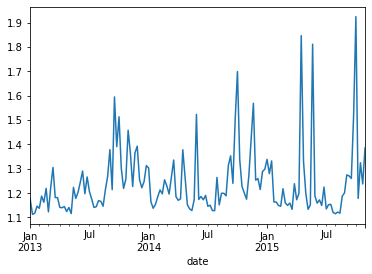

In [16]:
df_visu.item_cnt_day.resample('W').mean().plot()

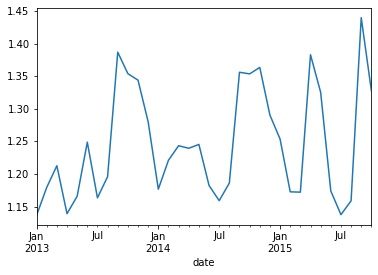

In [17]:
df_visu.item_cnt_day.resample('M').mean().plot()

**Converting the data to monthly basis and creating a pivot table**

In [18]:
df_month=df_final['date'].dt.month
df_year=df_final['date'].dt.year
df_final['date']=df_month.astype(str)+'/'+df_year.astype(str)
df_final

,index,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
0,0,1/2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,1,1/2013,0,24,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2,2,1/2013,0,27,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
3,3,1/2013,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
4,4,1/2013,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
...,...,...,...,...,...,...,...,...,...,...
2935844,2935844,10/2015,33,55,13093,250.0,1.0,Карта оплаты Windows: 250 рублей [Цифровая вер...,36,Карты оплаты - Windows (Цифра)
2935845,2935845,9/2015,32,55,13091,1000.0,1.0,Карта оплаты Windows: 1000 рублей [Цифровая ве...,36,Карты оплаты - Windows (Цифра)
2935846,2935846,9/2015,32,55,13094,2500.0,1.0,Карта оплаты Windows: 2500 рублей [Цифровая ве...,36,Карты оплаты - Windows (Цифра)
2935847,2935847,9/2015,32,55,13094,2500.0,2.0,Карта оплаты Windows: 2500 рублей [Цифровая ве...,36,Карты оплаты - Windows (Цифра)


In [19]:
df_grouped=df_final.groupby(['date','shop_id','item_id']).sum()


In [20]:
#Creating a pivot table with shopid as index and date as columns with item per day as values

df=df_grouped.pivot_table(index=['shop_id','item_id'],columns='date',values='item_cnt_day')
df=df.fillna(0)

In [21]:
df.reset_index(inplace=True)

In [22]:
df

date,shop_id,item_id,1/2013,1/2014,1/2015,10/2013,10/2014,10/2015,11/2013,11/2014,12/2013,12/2014,2/2013,2/2014,2/2015,3/2013,3/2014,3/2015,4/2013,4/2014,4/2015,5/2013,5/2014,5/2015,6/2013,6/2014,6/2015,7/2013,7/2014,7/2015,8/2013,8/2014,8/2015,9/2013,9/2014,9/2015
0,0,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424119,59,22154,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
424120,59,22155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
424121,59,22162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
424122,59,22164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


**Creating X_test for kaggle prediction**

In [23]:
X_test=pd.merge(df,df_test,on=['shop_id','item_id'],how='right')

In [24]:
X_test.shape

(214200, 37)

In [25]:
X_test.isnull().sum()

shop_id         0
item_id         0
1/2013     102796
1/2014     102796
1/2015     102796
10/2013    102796
10/2014    102796
10/2015    102796
11/2013    102796
11/2014    102796
12/2013    102796
12/2014    102796
2/2013     102796
2/2014     102796
2/2015     102796
3/2013     102796
3/2014     102796
3/2015     102796
4/2013     102796
4/2014     102796
4/2015     102796
5/2013     102796
5/2014     102796
5/2015     102796
6/2013     102796
6/2014     102796
6/2015     102796
7/2013     102796
7/2014     102796
7/2015     102796
8/2013     102796
8/2014     102796
8/2015     102796
9/2013     102796
9/2014     102796
9/2015     102796
ID              0
dtype: int64

In [26]:
X_test=X_test.fillna(0)

In [27]:
X_test

,shop_id,item_id,1/2013,1/2014,1/2015,10/2013,10/2014,10/2015,11/2013,11/2014,12/2013,12/2014,2/2013,2/2014,2/2015,3/2013,3/2014,3/2015,4/2013,4/2014,4/2015,5/2013,5/2014,5/2015,6/2013,6/2014,6/2015,7/2013,7/2014,7/2015,8/2013,8/2014,8/2015,9/2013,9/2014,9/2015,ID
0,5,5037,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,1.0,0
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,5,5233,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,2
3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,45,18454,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,214195
214196,45,16188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,214196
214197,45,15757,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,214197
214198,45,19648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,214198


In [28]:
X_test_new=X_test.drop(columns=['ID','1/2013','shop_id','item_id'])

In [29]:
X_test_new.shape

(214200, 33)

In [30]:
X_test_new

,1/2014,1/2015,10/2013,10/2014,10/2015,11/2013,11/2014,12/2013,12/2014,2/2013,2/2014,2/2015,3/2013,3/2014,3/2015,4/2013,4/2014,4/2015,5/2013,5/2014,5/2015,6/2013,6/2014,6/2015,7/2013,7/2014,7/2015,8/2013,8/2014,8/2015,9/2013,9/2014,9/2015
0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214197,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Train test split**

In [40]:
X=df.drop(columns=['10/2015','shop_id','item_id'])
y=df['10/2015'].values.reshape(-1,1)
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=42)

In [32]:
print(X.shape)
print(y.shape)

(424124, 33)
(424124, 1)


In [41]:
scaled=StandardScaler()
X_train_scaled=scaled.fit_transform(X_train)
y_scaled=scaled.fit_transform(y_train)
X_val_scaled=scaled.fit_transform(X_val)
y_val_scaled=scaled.fit_transform(y_val)
X_test_scaled=scaled.fit_transform(X_test_new)

**ANN**

In [62]:
#Plotting training loss and validation loss

def loss_plot(epochs,train_loss,val_loss):
  itr=np.arange(1,epochs+1)
  plt.plot(itr,train_loss,color='red',label='Training loss')
  plt.plot(itr,val_loss,color='green',label='Validation loss')
  plt.legend()
  plt.show()

In [102]:
#Training a ANN model

model=keras.Sequential()
model.add(keras.layers.Dense(units=150,activation='relu',input_dim=33))
model.add(keras.layers.Dense(units=200,activation='relu'))
model.add(keras.layers.Dense(units=200,activation='relu'))
model.add(keras.layers.Dense(units=1,activation='sigmoid'))
model.compile(optimizer='adam',loss='mean_squared_error')
callback=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 150)               5100      
_________________________________________________________________
dense_5 (Dense)              (None, 200)               30200     
_________________________________________________________________
dense_6 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 201       
Total params: 75,701
Trainable params: 75,701
Non-trainable params: 0
_________________________________________________________________


In [103]:
model_fitting=model.fit(x=X_train_scaled,y=y_scaled,epochs=30,validation_data=(X_val_scaled,y_val_scaled),callbacks=[callback])


Epoch 1/30
10604/10604 [==============================] - 25s 2ms/step - loss: 1.2104 - val_loss: 0.9619
Epoch 2/30
10604/10604 [==============================] - 24s 2ms/step - loss: 0.9944 - val_loss: 0.9520
Epoch 3/30
10604/10604 [==============================] - 24s 2ms/step - loss: 1.6150 - val_loss: 0.9526
Epoch 4/30
10604/10604 [==============================] - 24s 2ms/step - loss: 0.4420 - val_loss: 0.9521
Epoch 5/30
10604/10604 [==============================] - 24s 2ms/step - loss: 1.1323 - val_loss: 0.9446
Epoch 6/30
10604/10604 [==============================] - 24s 2ms/step - loss: 1.2743 - val_loss: 0.9519
Epoch 7/30
10604/10604 [==============================] - 24s 2ms/step - loss: 1.0921 - val_loss: 0.9504
Epoch 8/30
10604/10604 [==============================] - 24s 2ms/step - loss: 0.5807 - val_loss: 0.9501
Epoch 9/30
10604/10604 [==============================] - 25s 2ms/step - loss: 0.3950 - val_loss: 0.9503
Epoch 10/30
10604/10604 [==============================

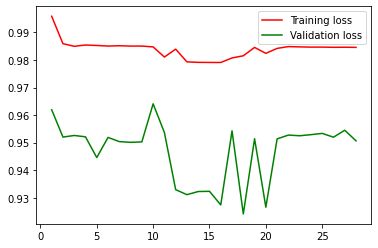

In [104]:
#Plot of training loss anad validation loss

train_loss=model_fitting.history['loss']
val_loss=model_fitting.history['val_loss']
loss_plot(len(train_loss),train_loss,val_loss)

**Hyper tuning the model**

In [78]:
def build_model(hp):
  model=keras.Sequential()
  model.add(keras.layers.Dense(units=hp.Int('units',min_value=50,max_value=300,step=50),activation='relu',input_dim=33))
  for i in range(hp.Int('hidden_layers',1,4)):
    model.add(keras.layers.Dense(units=hp.Int('hidden_units',min_value=50,max_value=300,step=50),activation='relu'))
  model.add(keras.layers.Dense(units=1,activation='sigmoid'))
  model.compile(optimizer='adam',loss='mean_squared_error')
  return model

In [95]:
tuner=RandomSearch(
    hypermodel=build_model,
    objective='val_loss',
    max_trials=3,
    executions_per_trial=1,
    directory='new_test',
    project_name='test'
)

INFO:tensorflow:Reloading Oracle from existing project new_test/test/oracle.json
INFO:tensorflow:Reloading Tuner from new_test/test/tuner0.json


In [96]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 300, 'step': 50, 'sampling': None}
hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
hidden_units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 300, 'step': 50, 'sampling': None}


In [97]:
tuner.search(x=X_train_scaled,y=y_scaled,epochs=15,validation_data=(X_val_scaled,y_val_scaled))

Trial 2 Complete [00h 06m 09s]
val_loss: 0.9398826360702515

Best val_loss So Far: 0.9398826360702515
Total elapsed time: 00h 11m 26s
INFO:tensorflow:Oracle triggered exit


In [101]:
tuner.results_summary()

Results summary
Results in new_test/test
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 150
hidden_layers: 2
hidden_units: 200
Score: 0.9398826360702515
Trial summary
Hyperparameters:
units: 200
hidden_layers: 2
hidden_units: 100
Score: 0.9450361132621765
Trial summary
Hyperparameters:
units: 250
hidden_layers: 2
hidden_units: 200
Score: 0.9526422917842865


**Predictions**

In [105]:
predictions=model.predict(X_test_scaled).round(1)

In [106]:
item=pd.DataFrame(predictions,columns=['item_cnt_month'])

In [107]:
data={
    'item_cnt_month':item['item_cnt_month']
}
df_sub=pd.DataFrame(data=data,index=X_test['ID'])
df_sub

,item_cnt_month
ID,
0,0.1
1,0.0
2,0.3
3,0.0
4,0.0
...,...
214195,0.0
214196,0.0
214197,0.0


In [108]:
df_sub.to_csv('sample_sub_final.csv')